# Sentiment classification with BERT

# Sentiment classification with BERT - Exploiting multi-layer feature extraction

`imdb_reviews` dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a *positive* or *negative* sentiment.
Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
* label (tf.int64)
* text (tf.string)

In this assignment, you will exploit multi-layer feature extraction of a BERT model which comprises of several Transformer-encoder blocks. The model you will be using is as follows:
- Name: small_bert/bert_en_uncased_L-4_H-128_A-2
- Number of layers, i.e., Transformer-encoder blocks: 4.
- Number of hidden states: 128.
- Number of attention heads: 2.
- Model on TFHub: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
- Preprocessing module on TFHub: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

Since the BERT model has 4 encoder blocks and each outputs an embedding feature vector, your task is to find a way to make use of the multi-layer features to boost the classification accuracy. There are some questions you need to figure out:
- How to get embedding feature vector of each encoder block.
- How to combine the embedding feature vectors of the encoder blocks.
- How to make use of the combined embedding feature vector to boost the model performance.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment-BERT-notebook.ipynb: Jupyter notebook containing source code.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text

!pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# Load the dataset


In [3]:
# Load and split the data into training, validation and test data
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete67K71I/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete67K71I/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete67K71I/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [4]:
# Show same samples (text reviews and labels) in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [5]:
from sklearn.model_selection import train_test_split
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16)   # Extract label (index 1) from numpy vector

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector

# Convert test set
# the test-set occupies 50% of the entire dataset (25000), now we use only 10%  which is 5000 samples and the rest will be added into train-set.
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16)  # Extract label (index 1) from numpy vector
X_train_added, X_test, y_train_added, y_test = train_test_split(
             X_test, y_test, test_size = 0.2, random_state=42)

# Convert lists to numpy arrays
X_train_added = np.array(X_train_added)
y_train_addded = np.array(y_train_added)
X_test = np.array(X_test)
y_test = np.array(y_test)
# add the additional train-set  into the original one.
X_train = np.concatenate((X_train, X_train_added), axis=0)
y_train = np.concatenate((y_train, y_train_added), axis=0)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (40000,)
y_train shape: (40000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (5000,)
y_test shape: (5000,)


In [7]:
### Below are two examples of BERT models with corresponding preprocessings for use with them
# Full list of BERT models supported by Tensorflow can be found at https://tfhub.dev/google/collections/bert/1

# Mapping from name to URL of Bert models
map_name_to_model = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
}

# Mapping from name to URL of respective processings for the Bert models
map_name_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

### Choose a model: Small BERT model for English language with L-2_H-128_A-2. This means the BERT model has:
# - 2 layers, i.e., 2 Transformer-encoder blocks.
# - Hidden states = 128.
# - Attention heads = 2.
# This Small BERT model is available at https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
bert_name = 'small_bert/bert_en_uncased_L-4_H-128_A-2'

# Get URLs of model and processing from tfhub
tfhub_model = map_name_to_model[bert_name]
tfhub_preprocess = map_name_to_preprocess[bert_name]

print('BERT model selected           : ' + str(tfhub_model))
print('Preprocess model auto-selected: ' + str(tfhub_preprocess))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Preprocess data to match with BERT model input requirement

In [8]:
# Load the preprocessing module
bert_preprocess = hub.KerasLayer(tfhub_preprocess)

In [9]:
### Analyze and understand the preprocessing module

# Some sample text reviews
sample_texts = ['It is a cool movie. The graphics and the animation are awesome.',
                'The movie was really bad. I would not recommend it to anyone.']

# Get the text reviews through the preprocessing module
sample_texts_preprocessed = bert_preprocess(sample_texts)

### Get outputs of the preprocessing module.
# There are three outputs from the preprocessing that a BERT model would use: input_words_id, input_mask and input_type_ids
# Note that the inputs are truncated to 128 tokens (words) for a fixed length.
print('Keys: ' + str(list(sample_texts_preprocessed.keys())))

# Shape of the input_words_id
print('Shape: ' + str(sample_texts_preprocessed["input_word_ids"].shape))

# Content of the input_words_id
print('Word Ids: ' + str(sample_texts_preprocessed["input_word_ids"]))

# Content of the input_mask
print('Input Mask: ' + str(sample_texts_preprocessed["input_mask"]))

# Content of the input_type_ids
print('Type Ids: ' + str(sample_texts_preprocessed["input_type_ids"]))

Keys: ['input_mask', 'input_word_ids', 'input_type_ids']
Shape: (2, 128)
Word Ids: tf.Tensor(
[[  101  2009  2003  1037  4658  3185  1012  1996  8389  1998  1996  7284
   2024 12476  1012   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  1996  3185  2001  2428  2919  1012  1045  2052  2025 16755  2009
   2000  3087  1012   102     0     0    

# Load BERT model

In [10]:
# Load the BERT model. This can be consider as an 'encoder'
bert_model = hub.KerasLayer(tfhub_model)

In [11]:
### Analyze and understand the BERT model.

# Get the output of preprocessing module through the BERT model (encoder)
bert_results = bert_model(sample_texts_preprocessed)

# Print the BERT model path on tfhub
print('Loaded BERT: ' + str(tfhub_model))

### The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs
# pooled_output: represents each input sequence as a whole. The shape is [batch_size, hidden_state]. This can be seen as an embedding for the entire movie review.
print('Pooled Outputs Shape: ' + str(bert_results["pooled_output"].shape))
print('Pooled Outputs Values: ' + str(bert_results["pooled_output"]))

# sequence_output: represents each input token in the context. The shape is [batch_size, seq_length, H]. This can be seen as a contextual embedding for every token (word) in the movie review.
print('Sequence Outputs Shape: ' + str(bert_results["sequence_output"].shape))
print('Sequence Outputs Values: ' + str(bert_results["sequence_output"]))

# When the BERT model has several Transfomer-encoder blocks, encoder_outputs are the intermediate activations of the L Transformer blocks.
# outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L.
# The last value of the list is equal to sequence_output.

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Pooled Outputs Shape: (2, 128)
Pooled Outputs Values: tf.Tensor(
[[ 5.74926510e-02  8.29617083e-01  2.21141815e-01 -9.07549977e-01
   8.77506971e-01 -9.37170535e-03 -8.67895126e-01  9.30034101e-01
   1.07965089e-01 -3.14920664e-01 -9.93551314e-01 -4.09096748e-01
   9.98683155e-01  9.99570131e-01 -9.76822793e-01  8.29320669e-01
   3.00475925e-01 -9.76671994e-01  9.66599107e-01 -9.95808959e-01
   9.91097152e-01  9.91468728e-01 -7.10828364e-01  9.98033881e-01
   9.98058319e-01  9.95148718e-01 -9.98793364e-01  5.59577122e-02
   3.31256568e-01  9.79301453e-01  1.88552272e-02  6.05523169e-01
  -9.93376076e-01 -4.56255525e-01 -9.97147202e-01  8.39755893e-01
   1.01908341e-01 -1.32392064e-01  6.24565601e-01 -5.92307091e-01
  -9.88178372e-01  7.48368442e-01  4.76031423e-01  6.41885251e-02
   5.26422262e-01  9.93735373e-01  6.07452989e-01 -9.72289503e-01
   8.06861185e-03  9.97892261e-01 -9.72344577e-01  8.67964

# Build complete model using preprocessing module, BERT model and classification layers

In [12]:
def build_model():
  text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  # Get the pooled_output
  pooled_output = outputs['pooled_output']

  # Get the outputs of the last two encoder blocks and average them
  averaged_outputs = [tf.reduce_mean(output, axis=1) for output in outputs['encoder_outputs'][-2:]]  # Modified to get only the last 2 blocks

  # Concatenate the averaged outputs and the pooled_output
  concatenated_outputs = tf.concat([pooled_output] + averaged_outputs, axis=-1)

  net = keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated_outputs)
  net = keras.layers.BatchNormalization()(net)
  net = keras.layers.Dropout(0.5)(net)
  # Add one more dense layer, batch normalization, and dropout
  net = keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
  net = keras.layers.BatchNormalization()(net)
  net = keras.layers.Dropout(0.5)(net)
  net = keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
  net = keras.layers.BatchNormalization()(net)
  net = keras.layers.Dropout(0.5)(net)

  net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

  return keras.Model(inputs=text_input, outputs=net, name="BERT_complete_model")

model = build_model()

model.summary()

Model: "BERT_complete_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                

# Training model

In [13]:
#  compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)  # Increased patience

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
625/625 [==============================] - 219s 322ms/step - loss: 1.7481 - accuracy: 0.5252 - val_loss: 1.4707 - val_accuracy: 0.6182
Epoch 2/50
625/625 [==============================] - 167s 267ms/step - loss: 1.6576 - accuracy: 0.5537 - val_loss: 1.4027 - val_accuracy: 0.6752
Epoch 3/50
625/625 [==============================] - 162s 260ms/step - loss: 1.5852 - accuracy: 0.5819 - val_loss: 1.3368 - val_accuracy: 0.7312
Epoch 4/50
625/625 [==============================] - 162s 259ms/step - loss: 1.5195 - accuracy: 0.6061 - val_loss: 1.2821 - val_accuracy: 0.7580
Epoch 5/50
625/625 [==============================] - 161s 257ms/step - loss: 1.4673 - accuracy: 0.6272 - val_loss: 1.2505 - val_accuracy: 0.7668
Epoch 6/50
625/625 [==============================] - 160s 256ms/step - loss: 1.4221 - accuracy: 0.6501 - val_loss: 1.2229 - val_accuracy: 0.7766
Epoch 7/50
625/625 [==============================] - 159s 254ms/step - loss: 1.3840 - accuracy: 0.6640 - val_loss: 1.1917 -

# Evaluate model performance on test set

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 12s 74ms/step - loss: 0.6563 - accuracy: 0.8468
Test Loss: 0.6562700271606445
Test Accuracy: 0.8468000292778015


# Plot model training performance over epochs

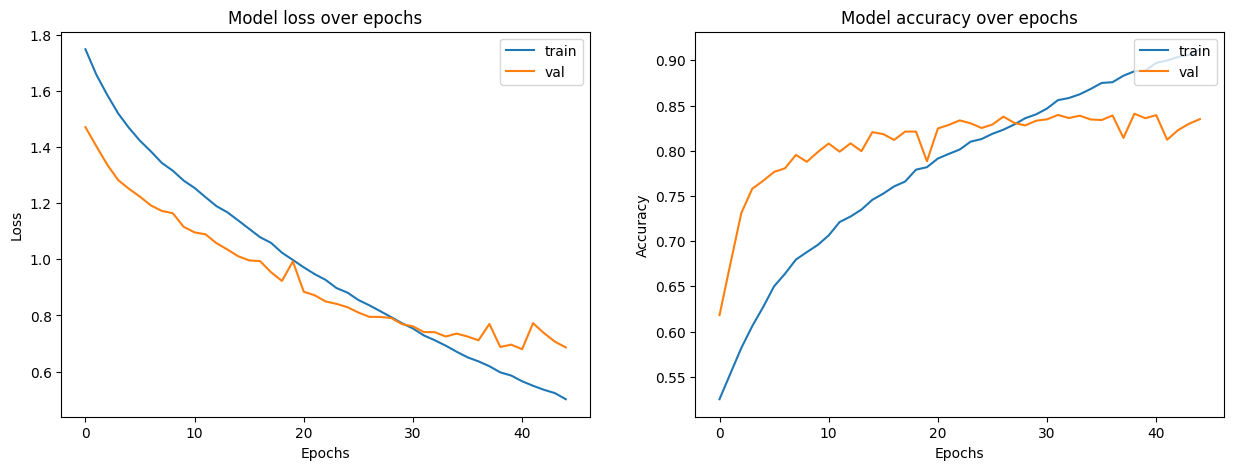

In [15]:
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot model loss during training
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Model loss over epochs")

# Plot model accuracy during training
ax2.plot(history.history["accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Model accuracy over epochs")
plt.show()

# Predict some movie review samples

In [16]:
# Make prediction on new text reviews
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 1s 523ms/step
[0.9965926]
[0.01992527]
